In [28]:
# import modules
import numpy as np
import matplotlib.pyplot as plt
import joblib
import pandas as pd

In [2]:
# noisy_bnsp modules
from noisy_bnsp import NSGammaModel, EstConfig, Estimator

## Simulation

In [3]:
# define random number generator
rng = np.random.default_rng(0)

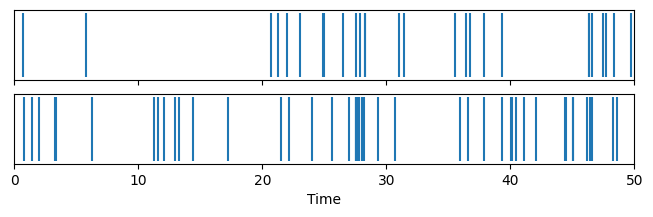

In [4]:
# define model
model = NSGammaModel()
# specify parameters
true_full_params = np.array([
    0.1, # lambda (constant intensity of parent Poisson process)
    2,  # sigma_1 (rate parameter of Poisson distribution, the expected number of children for the 1st component)
    4,  # sigma_2 (same as above, but for the 2nd component)
    0.3,  # alpha_1 (shape parameter of the gamma kernel for the 1st component)
    0.4,  # alpha_2 (same as above, but for the 2nd component)
    1,  # l_1 (rate parameter of the gamma kernel for the 1st component)
    1,  # l_2 (same as above, but for the 2nd component)
    0.5, # rate of the noise Poisson process for the 1st component
    0.5  # rate of the noise Poisson process for the 2nd component
    ])

# simulate the bivariate process on [0, T]
T = 50
data = model.simulate(
    rng=rng,
    T=T,
    full_params=true_full_params
)
# return tuple of 1D numpy arrays
assert len(data) == 2
for d in data:
    assert d.ndim == 1

# plot event time by vertical lines
fig, ax = plt.subplots(2, 1, figsize=(8, 2), sharex=True)
for i, d in enumerate(data):
    ax[i].vlines(d, 0, 1)
    ax[i].set_yticks([])
    ax[i].set_xlim(0, T)
ax[1].set_xlabel('Time')
plt.show()

## Estimation

In [ ]:
# Generate artificial data
model = NSGammaModel()
T = 10000
true_full_params = np.array([0.1, 2, 4, 0.3, 0.4, 1, 1, 0, 0])
data = model.simulate(rng, T, true_full_params)

# Parameters to be estimated: (a, alpha_1, alpha_2, l_1, l_2)
# where a is some function of lambda, sigma_1, sigma_2, and the noise rates
# For the details, see the document or arXiv:2410.05732
# Note: not all parameters are estimated in this model.
true_params = model.convert_params(true_full_params)

In [23]:
# specify the configuration of the estimator
# C implementation is about 30x faster than Python implementation in my environment
cfg = EstConfig(
    T=T,  # specify the length of the observation window
    obj="wl_c",  # the objective function. "wl" for Python implementation, and "wl_c" for C implementation
    r=1.0,  # the range of correlation (hyperparameter)
    opt_method="Nelder-Mead",
    initial_param=np.array([10. ,  0.3,  0.4,  1. ,  1. ]),
    opt_bound="auto",
)

# estimate the parameters
model = NSGammaModel()
est = Estimator(
        data[0],  # pass the first component of the data
        data[1],  # pass the second component of the data
        model=model,  # pass the model
        cfg=cfg  # pass the configuration
    )
result = est.estimate()  # then call the estimate method

In [26]:
# We have estimated the parameters near the true parameters
print(f"True parameters: {true_params}")
print(f"Estimated parameters: {result}")

True parameters: [10.   0.3  0.4  1.   1. ]
Estimated parameters: [11.42176632  0.28850975  0.42119093  0.82596341  1.07301578]


In [33]:
# Monte Carlo simulation to confirm convergence to the true parameters
MC = 500
res_df_list = []
for T in [2500, 5000, 10000]:
    true_full_param = np.array([0.1, 2, 4, 0.3, 0.4, 1, 1, 0, 0])  # no noise
    true_param = NSGammaModel.convert_params(true_full_param)
    cfg = EstConfig(
        T=T,
        obj="wl_c",
        r=1.0,
        opt_method="Nelder-Mead",
        initial_param=true_param,
        opt_bound="auto",
    )

    # get the sequence of generators to avoid the seed collision
    ss = np.random.SeedSequence(42)
    child_seeds = ss.spawn(MC)
    streams = [np.random.default_rng(s) for s in child_seeds]

    # wrap the estimate function for parallel processing
    def main(rng: np.random.Generator) -> np.ndarray:
        data1, data2 = NSGammaModel().simulate(rng, T, true_full_param)
        est = Estimator(data1=data1, data2=data2, model=NSGammaModel(), cfg=cfg)
        return est.estimate()

    # simulate and estimate the parameters in parallel
    res = joblib.Parallel(n_jobs=-1, verbose=10)(
        joblib.delayed(main)(rng) for rng in streams
    )

    res_df = pd.DataFrame(res, columns=["a", "a1", "a2", "l1", "l2"]) # type: ignore
    res_df_list.append(res_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done  30 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done  41 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  52 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  78 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  93 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 108 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done 125 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 161 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 180 tasks      | elapsed:   14.3s
[Parallel(n_jobs=-1)]: Done 201 tasks      | elapsed:  

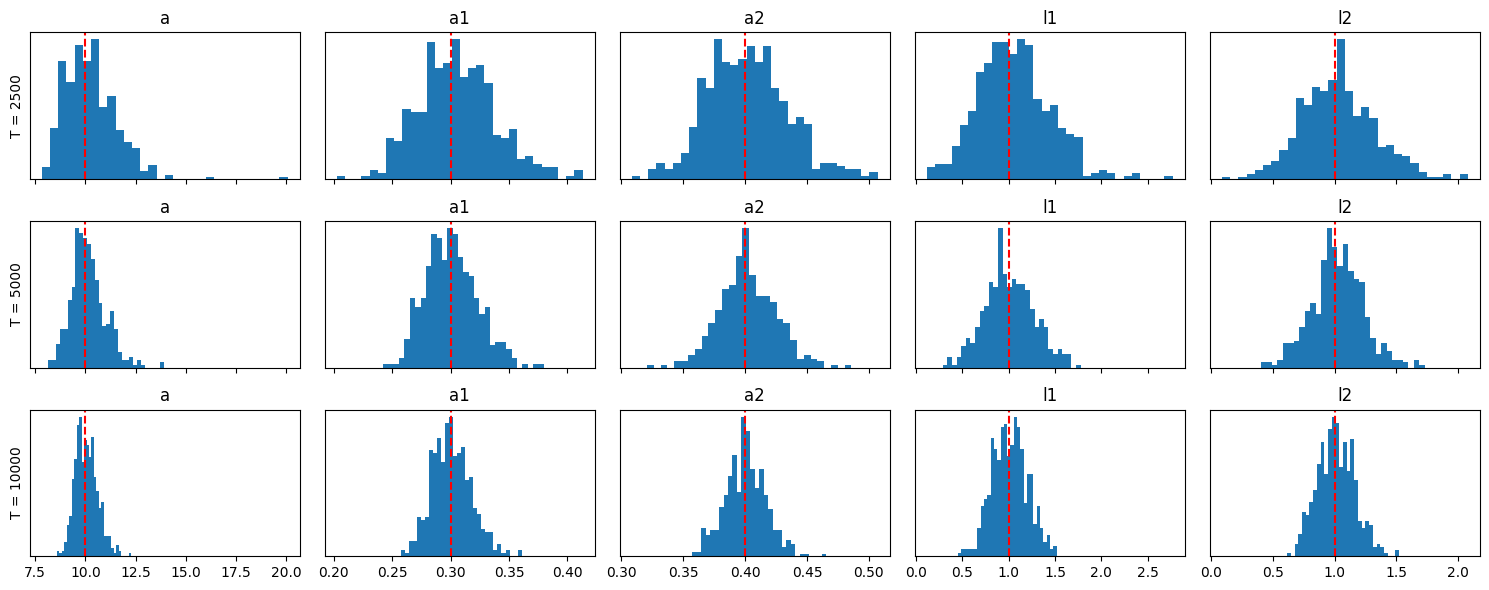

In [42]:
# We can see that the estimated parameters are converging to the true parameters as T increases

fig, axs = plt.subplots(3, 5, figsize=(15, 6), sharex="col")
for i, res_df in enumerate(res_df_list):
    for j, col in enumerate(res_df.columns):
        axs[i, j].hist(res_df[col], bins=30)
        axs[i, j].set_title(col)
        true_val = true_param[j]
        axs[i, j].axvline(true_val, color="red", linestyle="--")
        axs[i, j].set_yticks([])
    axs[i, 0].set_ylabel(f"T = {2500 * 2 ** i}")

fig.tight_layout()